# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tqdm import tqdm

import keras
import tensorflow as tf
from keras import *


CACHE_DIR = Path("images_cache")
CHECKPOINT_DIR = Path("checkpoints")
DATA_DIR = CHECKPOINT_DIR / "data"

print(f"Dossier de cache : {CACHE_DIR}")

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)


2025-12-11 19:35:01.278659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 19:35:01.278862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 19:35:01.306629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dossier de cache : images_cache


2025-12-11 19:35:01.961576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 19:35:01.961797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Partie 1 : Analyse approfondie du jeu de données

### 1. Exploration initiale

On charge les données :

In [2]:
data = pd.read_parquet(DATA_DIR / 'data.parquet')

On prend connaissance des dimensions du dataset :

In [3]:
data.shape

(1428, 17)

On prend aussi connaissance du type de chaque colonne :

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   website_name     1428 non-null   object 
 1   competence_date  1428 non-null   object 
 2   country_code     1428 non-null   object 
 3   currency_code    1428 non-null   object 
 4   brand            1428 non-null   object 
 5   category1_code   1428 non-null   object 
 6   category2_code   1428 non-null   object 
 7   category3_code   1428 non-null   object 
 8   product_code     1428 non-null   object 
 9   title            1428 non-null   object 
 10  itemurl          1428 non-null   object 
 11  imageurl         1428 non-null   object 
 12  full_price       1428 non-null   float64
 13  price            1428 non-null   float64
 14  full_price_eur   1428 non-null   float64
 15  price_eur        1428 non-null   float64
 16  flg_discount     1428 non-null   int64  
dtypes: float64(4),

On vérifie s'il y a des valeurs nulles :

In [5]:
data.isna().sum()

website_name       0
competence_date    0
country_code       0
currency_code      0
brand              0
category1_code     0
category2_code     0
category3_code     0
product_code       0
title              0
itemurl            0
imageurl           0
full_price         0
price              0
full_price_eur     0
price_eur          0
flg_discount       0
dtype: int64

En l'occurence, ce dataset ne comporte pas de valeurs nulles.

Voici un aperçu des 5 premières lignes du dataset :

In [6]:
data.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0


On remarque que certaines colonnes ont l'air d'avoir une seule valeur pour toutes les entrées, on y remédiera dans la prochaine sous-section.

On recueilles les statistiques sur les données quantitatives :

In [7]:
data.describe()

,full_price,price,full_price_eur,price_eur,flg_discount
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.0
mean,6076.253725,6076.253725,6076.253725,6076.253725,0.0
std,15219.005999,15219.005999,15219.005999,15219.005999,0.0
min,23.000000,23.000000,23.000000,23.000000,0.0
25%,195.000000,195.000000,195.000000,195.000000,0.0
50%,1415.000000,1415.000000,1415.000000,1415.000000,0.0
75%,5800.000000,5800.000000,5800.000000,5800.000000,0.0
max,142000.000000,142000.000000,142000.000000,142000.000000,0.0


On remarque que ces colonnes présentent les mêmes statistiques, il est possible que ces quatres colonnes comportent les mêmes valeurs pour chaque entrée. On vérifie cela :

In [8]:
colonnes = ['full_price', 'price', 'full_price_eur', 'price_eur']
(data[colonnes].nunique(axis=1)==1).all()

np.True_

Ces quatres colonnes sont effectivement identiques.

On écrit une fonction pour analyser la qualité et la diversité des images (dimensions, couleurs, formats) :

In [9]:
def analyze_image_quality(df, sample_size=50):
    print(f"Analyse de {sample_size} images aléatoires :")
    sample = df.sample(sample_size, random_state=42)
    widths = []
    heights = []
    modes = []
    
    for _, row in sample.iterrows():
        try:
            response = requests.get(row['imageurl'], timeout=3)
            img = Image.open(BytesIO(response.content))
            w, h = img.size
            widths.append(w)
            heights.append(h)
            modes.append(img.mode)
        except Exception as e:
            print(f"Erreur de chargement pour {row['product_code']}")

    # Visualisation des dimensions
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.6, c='blue')
    plt.title(f"Dimensions des images (Echantillon n={sample_size})")
    plt.xlabel("Largeur (px)")
    plt.ylabel("Hauteur (px)")
    plt.show()
    
    print(f"Dimensions uniques trouvées : {set(zip(widths, heights))}")
    print(f"Modes de couleurs trouvés : {set(modes)}")

On lance l'analyse :

Analyse de 50 images aléatoires :
Erreur de chargement pour PJ12307
Erreur de chargement pour PAP3604B14342
Erreur de chargement pour PJ12118
Erreur de chargement pour PP140730
Erreur de chargement pour PAP0953B04852
Erreur de chargement pour PPH6593
Erreur de chargement pour PJ12157
Erreur de chargement pour PP140680
Erreur de chargement pour PPH7609
Erreur de chargement pour PP120900
Erreur de chargement pour PP143030
Erreur de chargement pour PP107809
Erreur de chargement pour PJ12071
Erreur de chargement pour PP102940
Erreur de chargement pour PJ12091
Erreur de chargement pour PP102440
Erreur de chargement pour PA92193Y09953
Erreur de chargement pour PA71547
Erreur de chargement pour PP144260
Erreur de chargement pour PP126300
Erreur de chargement pour PG31318Y50006
Erreur de chargement pour PA75272
Erreur de chargement pour PP147540


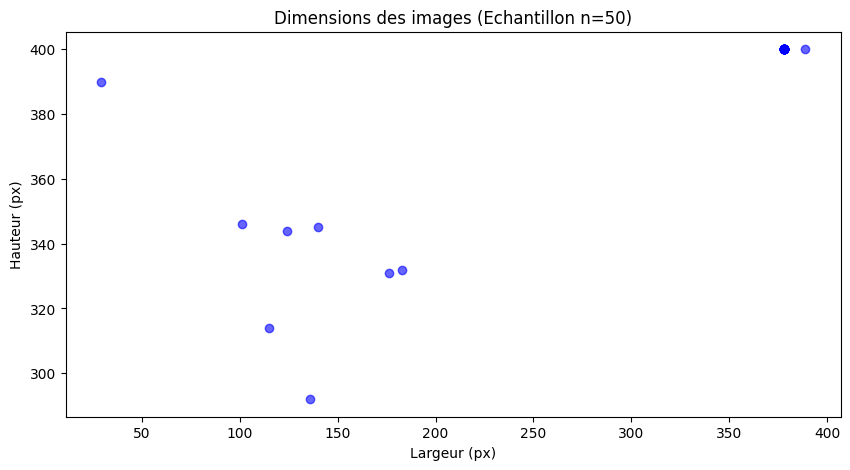

Dimensions uniques trouvées : {(183, 332), (140, 345), (176, 331), (124, 344), (115, 314), (136, 292), (378, 400), (389, 400), (101, 346), (29, 390)}
Modes de couleurs trouvés : {'P', 'RGB'}


In [10]:
analyze_image_quality(data, sample_size=50)

On remarque qu'on a des erreurs de chargement sur certaines images. En fait, ces images ne sont pas accessibles.

Aussi, les images ont des tailles très variées et des rations différents. Il faudra sûrement implémenter une étape de redimensionnement et probablement de padding pour ne pas déformer les images tout en les adaptant à un format convenable pour certains modèles de deep learning (comme ResNet ou les CNN).

Enfin, il y a des images en RGB, mais il y en a aussi en P (Palette). Il faudra convertir ces dernières en RGB pour les modèles de vision.

### 2. Préparation des données

On supprime les colonnes pour lesquelles la même valeur est présente pour toutes les entrées :

In [11]:
for colonne in data.columns:
    if data[colonne].nunique() == 1 :
        data.drop(colonne, axis = 1, inplace = True)
        print("La colonne " + colonne + "a été supprimée")

La colonne website_namea été supprimée
La colonne competence_datea été supprimée
La colonne country_codea été supprimée
La colonne currency_codea été supprimée
La colonne branda été supprimée
La colonne category3_codea été supprimée
La colonne flg_discounta été supprimée


On ne garde aussi qu'une seule colonne parmi `full_price`, `price`, `full_price_eur`, et `price_eur` puisqu'elles sont identiques :

In [12]:
colonnes = ['full_price','full_price_eur', 'price_eur']
data.drop(colonnes, axis=1, inplace=True)

Voici un aperçu du dataframe nettoyé :

In [13]:
data.head()

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
0,FASHION,HANDBAGS,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0
1,FASHION,HANDBAGS,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0
2,EYEWEAR,BLUE LIGHT GLASSES,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0
3,EYEWEAR,SUNGLASSES,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0
4,EYEWEAR,SUNGLASSES,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0


### 3. Visualisation

On représente la distribution des catégories :

<Axes: ylabel='count'>

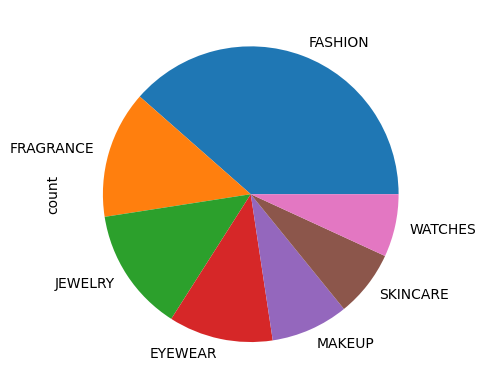

In [14]:
data.category1_code.value_counts().plot.pie()

In [15]:
data.category2_code.value_counts()

category2_code
READY-TO-WEAR                  243
COSTUME JEWELRY                127
SUNGLASSES                      99
WOMEN                           88
WATCHES                         87
MEN                             72
HANDBAGS                        61
COCO CRUSH                      54
SHOES                           42
FACE                            41
EYEGLASSES                      40
SMALL LEATHER GOODS             38
BATH AND BODY                   36
EYES                            35
MOISTURIZERS                    35
RINGS                           35
NECKLACES                       30
BRUSHES AND ACCESSORIES         26
EARRINGS                        26
BLUE LIGHT GLASSES              24
LIPS                            21
N°5                             15
EXCEPTIONAL PIECES              11
CLEANSERS & MAKEUP REMOVERS     11
TONERS & LOTIONS                11
BELTS                           10
BRACELETS                        9
OILS                             9
HEADW

/tmp/ipykernel_20158/665404679.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')


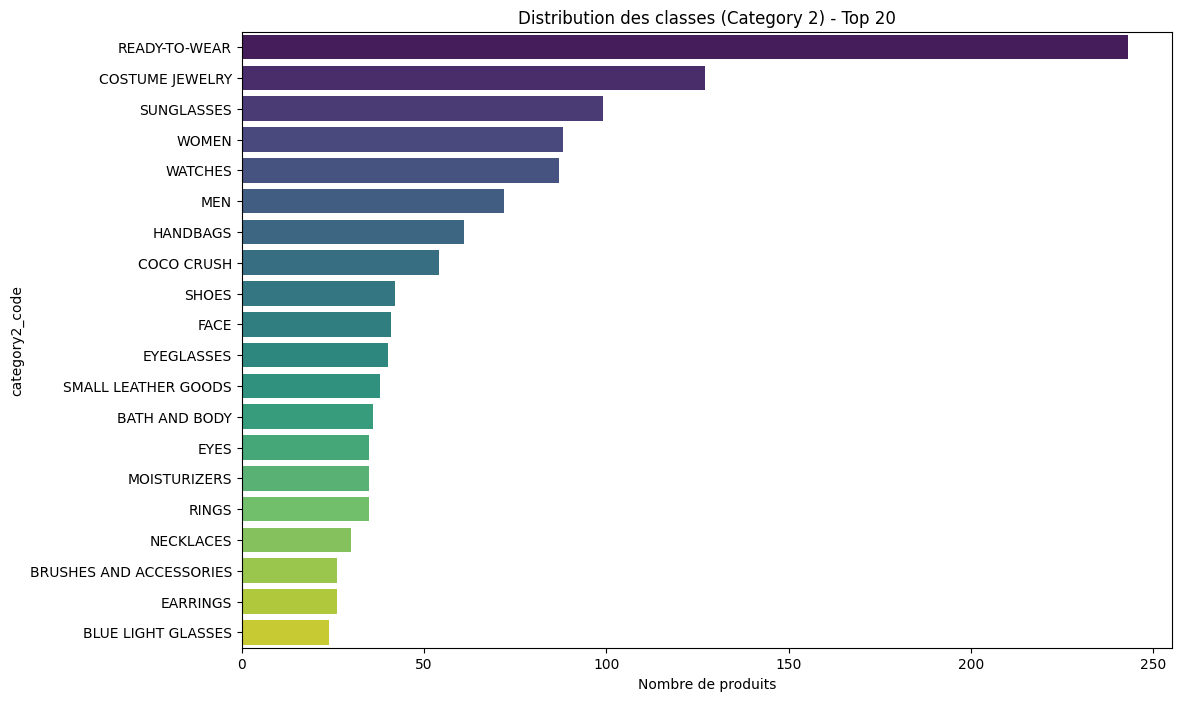

La classe majoritaire (READY-TO-WEAR) représente 17.0% du dataset.


In [16]:
plt.figure(figsize=(12, 8))
# On affiche le Top 20 des catégories pour la lisibilité
top_cats = data['category2_code'].value_counts().nlargest(20)
sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')
plt.title('Distribution des classes (Category 2) - Top 20')
plt.xlabel('Nombre de produits')
plt.show()

# Analyse du biais
print(f"La classe majoritaire ({top_cats.index[0]}) représente {top_cats.iloc[0]/len(data):.1%} du dataset.")

On remarque que la distribution de `category2_code` est très hétérogène.

On représente la distribution des prix :

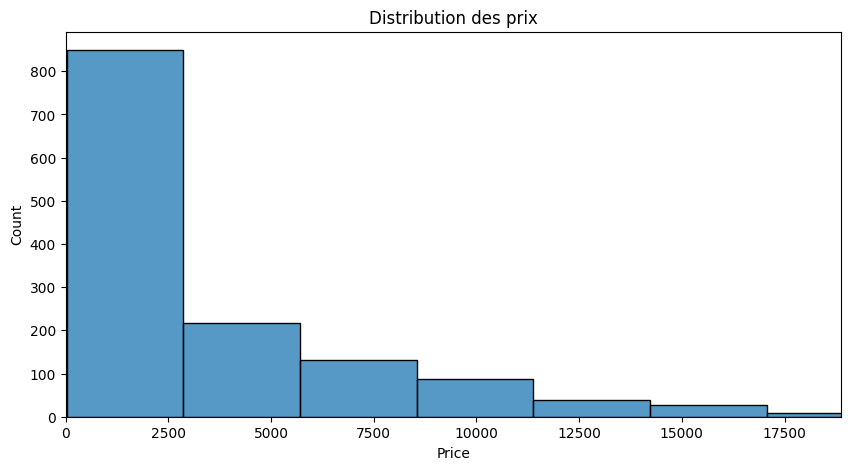

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(data['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution des prix')
plt.xlim(0, data['price'].quantile(0.95)) # On coupe les valeurs extrêmes pour y voir clair
plt.show()

Voici les cinq produits les plus chers :

In [18]:
data.nlargest(5,'price')

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
1216,JEWELRY,RINGS,PJ63142,18 Karat Weißgold Diamanten schwarze Spinelle,https://www.chanel.com/de/schmuck/p/J63142/com...,https://res.cloudinary.com/dwayrkp5z/image/fet...,142000.0
790,JEWELRY,LES INTEMPORELS DE CHANEL,PJ60909,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J60909/rub...,https://res.cloudinary.com/dwayrkp5z/image/fet...,132000.0
1332,WATCHES,EXCEPTIONAL PIECES,PPH7431,Extrem widerstandsfähige weiße Keramik und Wei...,https://www.chanel.com/de/uhren/p/H7431/j12-ba...,https://res.cloudinary.com/dwayrkp5z/image/fet...,130000.0
788,JEWELRY,BRACELETS,PJ2831,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J2831/come...,https://res.cloudinary.com/dwayrkp5z/image/fet...,123000.0
437,WATCHES,EXCEPTIONAL PIECES,PPH6949,Großes Modell BEIGEGOLD und Diamanten goldbr...,https://www.chanel.com/de/uhren/p/H6949/boy-fr...,https://res.cloudinary.com/dwayrkp5z/image/fet...,120000.0


On représente les longueurs des titres :

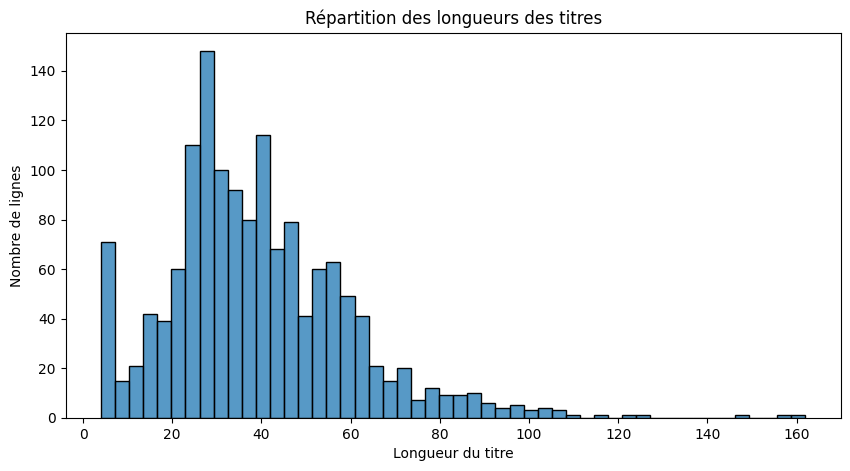

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(data['title'].str.len(), bins=50)
plt.xlabel('Longueur du titre')
plt.ylabel('Nombre de lignes')
plt.title('Répartition des longueurs des titres')
plt.show()

On nettoie les titres en mettant tout en minuscule et en supprimant les espaces avant/après :

In [20]:
data['clean_title'] = data['title'].str.lower().str.strip()

On vérifie la présence de doublons dans les titres :

In [21]:
duplicates = data[data.duplicated(subset=['clean_title'], keep=False)]
print(f"Nombre de titres dupliqués : {len(duplicates)}")
print(f"Proportion de titres dupliqués : {len(duplicates)/len(data['title']):.2%}")

Nombre de titres dupliqués : 806
Proportion de titres dupliqués : 56.44%


Il y a 56.44 % de titres dupliqués. C'est un chiffre très élevé. Cela signifie que notre modèle textuel aura beaucoup de mal à distinguer les produits. Si l'utilisateur tape un titre, le système textuel verra 50 articles identiques. Le texte seul est donc insuffisant pour discriminer les produits, l'image (qui montre la couleur spécifique) sera donc nécessaire.

On visualise les tittres nettoyés :

In [22]:
display(data[['title', 'clean_title']].head())

,title,clean_title
0,Tweed & goldfarbenes Metall Schwarz Rosa & B...,tweed & goldfarbenes metall schwarz rosa & b...
1,n.a.,n.a.
2,Schwarz,schwarz
3,Silberfarben. Gläser: Braun Mit Verlauf,silberfarben. gläser: braun mit verlauf
4,Blau & Rosa. Gläser: Grau Mit Verlauf,blau & rosa. gläser: grau mit verlauf


On écrit une fonction pour afficher cinq exemples de produits pour les trois catégories les plus fréquentes :

In [23]:
def show_category_examples(df, category_col='category2_code', n_examples=5):
    top_categories = df[category_col].value_counts().head(3).index.tolist()
    
    for cat in top_categories:
        print(f"Catégorie : {cat}")
        subset = df[df[category_col] == cat].sample(n_examples)
        
        plt.figure(figsize=(15, 5))
        for i, (_, row) in enumerate(subset.iterrows()):
            try:
                response = requests.get(row['imageurl'], timeout=3)
                img = Image.open(BytesIO(response.content))
                
                plt.subplot(1, n_examples, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{row['price']}€", fontsize=10)
            except:
                pass
        plt.show()

On exécute cette fonction d'affichage :

Catégorie : READY-TO-WEAR


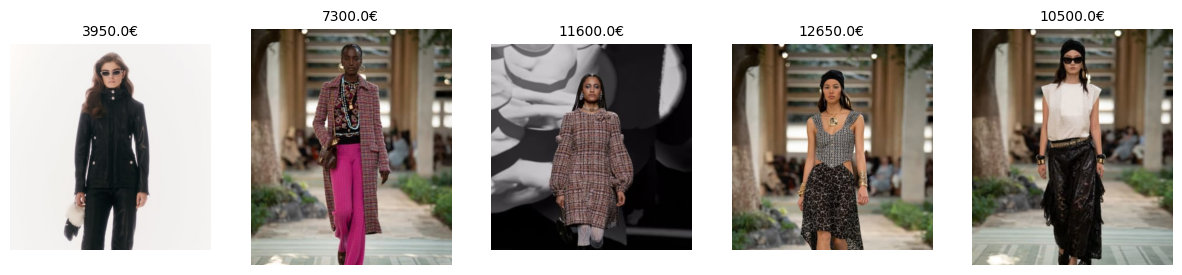

Catégorie : COSTUME JEWELRY


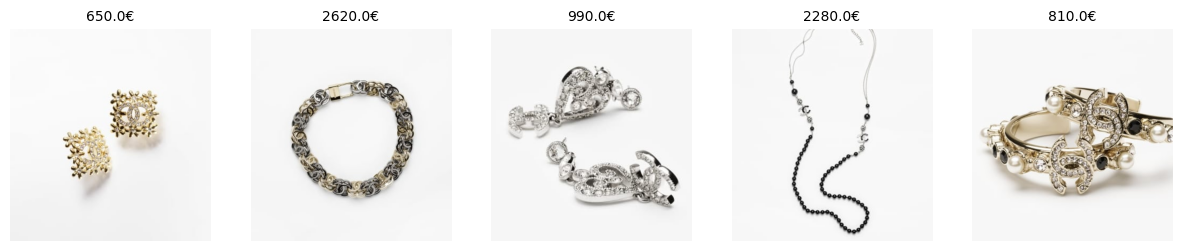

Catégorie : SUNGLASSES


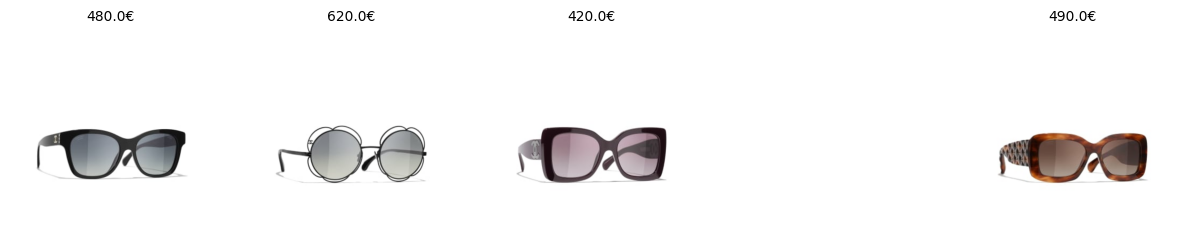

In [24]:
show_category_examples(data)

On note que les correspondances entre les images, les descriptions et les catégories sont cohérentes.

On représente la distribution des prix par catégorie  sous la forme d'une boîte à moustache :

/tmp/ipykernel_20158/4028035275.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")


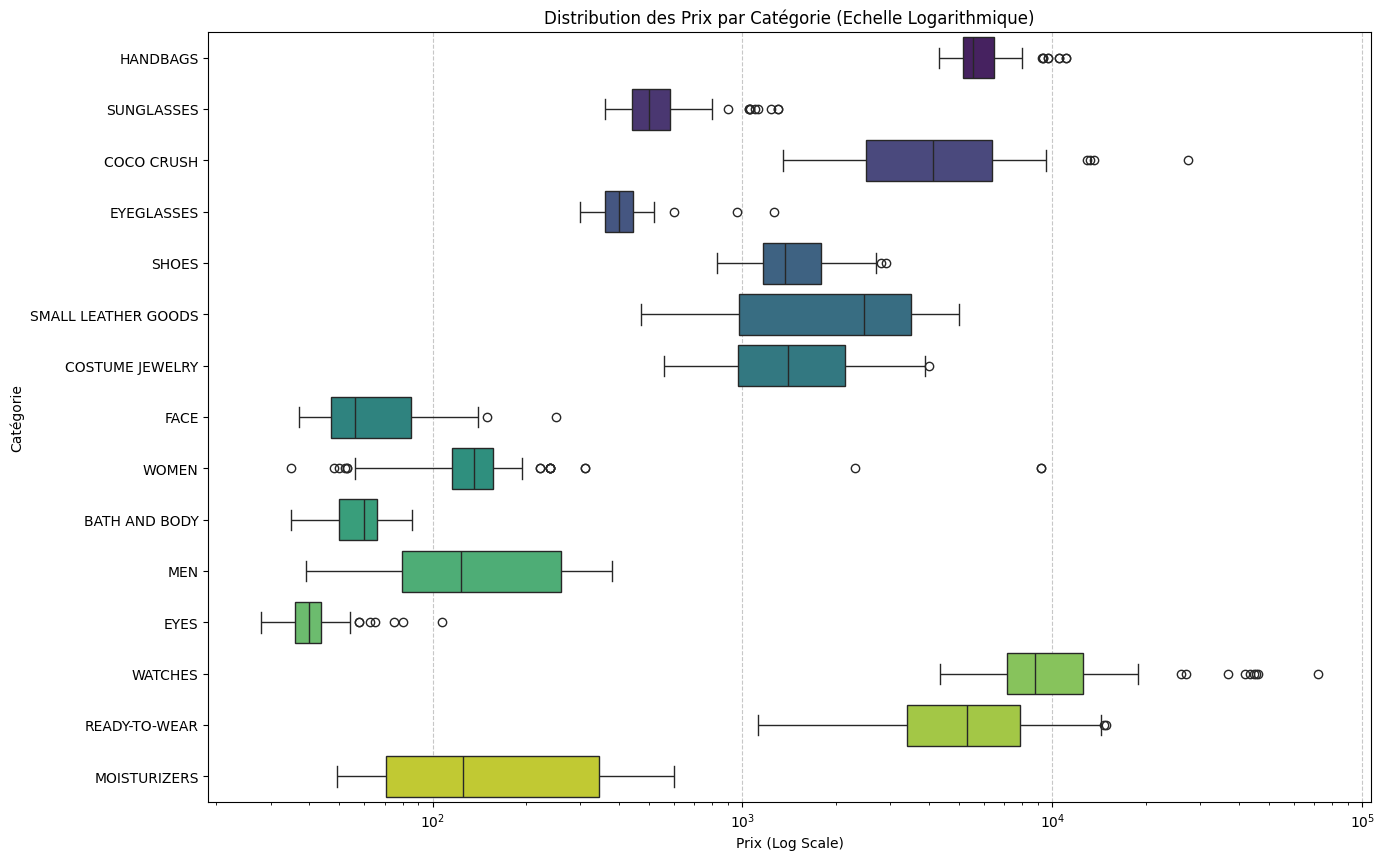

In [25]:
# Configuration de la taille
plt.figure(figsize=(15, 10))

# On ne garde que les catégories avec assez de produits pour que le graph soit lisible
top_cats_list = data['category2_code'].value_counts().nlargest(15).index
data_filtered = data[data['category2_code'].isin(top_cats_list)]

# Création du Boxplot
sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")

# Affichage en échelle logarithmique
plt.xscale('log') 
plt.title('Distribution des Prix par Catégorie (Echelle Logarithmique)')
plt.xlabel('Prix (Log Scale)')
plt.ylabel('Catégorie')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

On remarque que les montres représentent la catégorie avec la plus grande dispersion. Cela montre que Chanl vend à la fois des montres abordables et des pièces de haute horlogerie. Concernant les sacs, la médiane de cette catégorie est très élevée, cela signifie qu'il n'y a pas de sac "pas cher" chez Chanel.

En tout cas, cette visualisation met en évidence une segmentation tarifaire en trois tiers : les cosmétiques (entrée de gamme), les accessoires de mode (milieu de gamme), et les pièces de haute valeur (haut de gamme).

### 4. Analyses complémentaires

Quelques statistiques supplémentaires pour mieux comprendre les données.

=== Corrélation Prix / Longueur du titre ===
Corrélation de Pearson : 0.0950

=== Répartition par catégorie principale (category1_code) ===
category1_code
FASHION      550
FRAGRANCE    199
JEWELRY      193
EYEWEAR      163
MAKEUP       121
SKINCARE     104
WATCHES       98
Name: count, dtype: int64

=== Analyse du déséquilibre des classes ===
Nombre de classes : 51
Classe la plus fréquente : READY-TO-WEAR (243 produits)
Classe la moins fréquente : BODY (1 produits)
Ratio max/min : 243.0x

Classes avec < 5 échantillons : 14


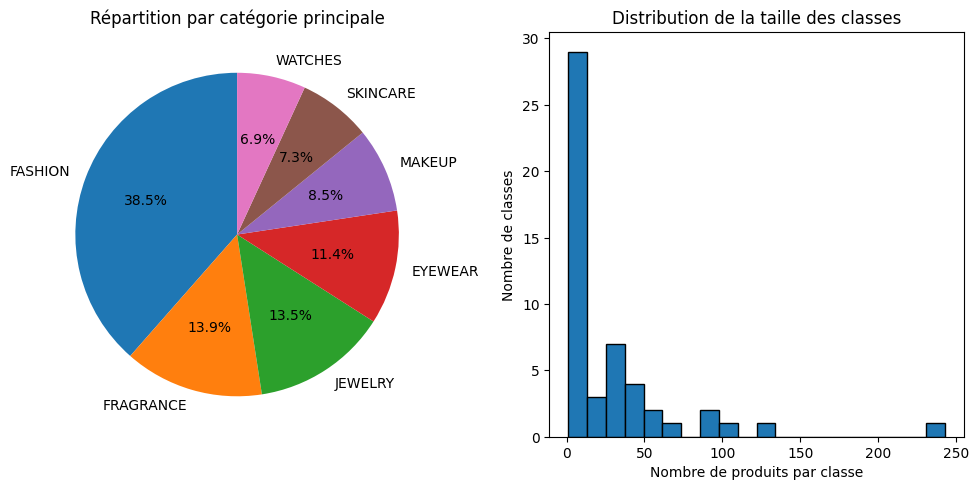

In [26]:
# Analyse de la corrélation entre prix et longueur du titre
print("=== Corrélation Prix / Longueur du titre ===")
data['title_length'] = data['title'].str.len()
correlation_price_title = data['price'].corr(data['title_length'])
print(f"Corrélation de Pearson : {correlation_price_title:.4f}")

# Distribution des produits par catégorie principale
print("\n=== Répartition par catégorie principale (category1_code) ===")
cat1_counts = data['category1_code'].value_counts()
print(cat1_counts)

# Analyse du déséquilibre des classes
print("\n=== Analyse du déséquilibre des classes ===")
cat2_counts = data['category2_code'].value_counts()
print(f"Nombre de classes : {len(cat2_counts)}")
print(f"Classe la plus fréquente : {cat2_counts.index[0]} ({cat2_counts.iloc[0]} produits)")
print(f"Classe la moins fréquente : {cat2_counts.index[-1]} ({cat2_counts.iloc[-1]} produits)")
print(f"Ratio max/min : {cat2_counts.iloc[0] / cat2_counts.iloc[-1]:.1f}x")

# Classes avec très peu d'échantillons (problématique pour l'entraînement)
rare_classes = cat2_counts[cat2_counts < 5]
print(f"\nClasses avec < 5 échantillons : {len(rare_classes)}")

# Visualisation du déséquilibre
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cat1_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Répartition par catégorie principale')
plt.ylabel('')

plt.subplot(1, 2, 2)
plt.hist(cat2_counts.values, bins=20, edgecolor='black')
plt.xlabel('Nombre de produits par classe')
plt.ylabel('Nombre de classes')
plt.title('Distribution de la taille des classes')
plt.tight_layout()
plt.show()

#### Analyse des mots-clés dans les titres

On extrait les mots les plus fréquents dans les titres pour comprendre le vocabulaire du catalogue.

=== Top 20 des mots les plus fréquents dans les titres ===
  schwarz: 399
  metall: 211
  diamanten: 197
  karat: 196
  mit: 155
  und: 153
  goldfarben: 136
  gläser: 114
  strass: 101
  eau: 92
  kristall: 79
  grau: 78
  silberfarben: 75
  für: 71
  edelstahl: 71
  modell: 66
  parfum: 65
  rosa: 62
  verlauf: 61
  goldfarbenes: 60


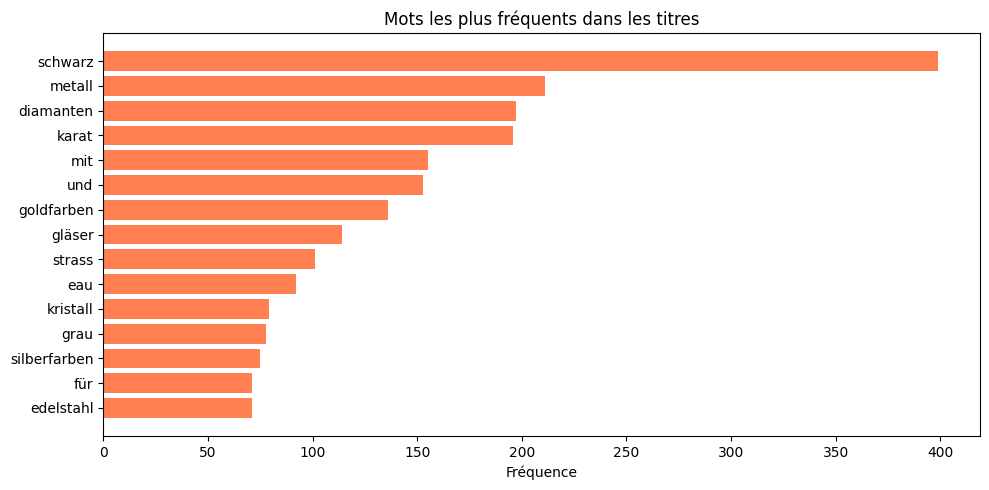

In [27]:
from collections import Counter
import re

# Extraction des mots (en minuscules, sans ponctuation)
all_words = []
for title in data['clean_title']:
    words = re.findall(r'\b[a-zA-Zàâäéèêëïîôùûüç]+\b', str(title).lower())
    all_words.extend([w for w in words if len(w) > 2])  # Ignorer les mots très courts

word_counts = Counter(all_words)

# Top 20 des mots les plus fréquents
print("=== Top 20 des mots les plus fréquents dans les titres ===")
for word, count in word_counts.most_common(20):
    print(f"  {word}: {count}")

# Visualisation
top_words = dict(word_counts.most_common(15))
plt.figure(figsize=(10, 5))
plt.barh(list(top_words.keys())[::-1], list(top_words.values())[::-1], color='coral')
plt.xlabel('Fréquence')
plt.title('Mots les plus fréquents dans les titres')
plt.tight_layout()
plt.show()

In [28]:
# Note: La sauvegarde finale du dataset nettoyé (avec images valides uniquement) 
# se fait à la fin du notebook après le filtrage des images

### 4. Pipeline de préparation des images pour l'entraînement

Cette section implémente un pipeline complet pour préparer les images :
1. Téléchargement et mise en cache locale
2. Conversion RGB
3. Redimensionnement avec padding
4. Normalisation
5. Encodage des labels et split train/val/test
6. Augmentations de données
7. Pipeline tf.data performant

#### 4.1 Configuration et imports supplémentaires

In [29]:
# Configuration
IMG_SIZE = (224, 224)  # Taille standard pour ResNet, VGG, etc.
BATCH_SIZE = 16
SEED = 42

print(f"Configuration : IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}")


Configuration : IMG_SIZE=(224, 224), BATCH_SIZE=16


#### 4.2 Téléchargement et mise en cache des images

On télécharge les images, on les convertit en RGB, on les redimensionne avec padding (pour conserver le ratio) et on les sauvegarde localement.

In [30]:
def resize_with_padding(img, target_size):
    """
    Redimensionne une image en conservant le ratio d'aspect.
    Ajoute du padding blanc pour atteindre la taille cible.
    """
    # Calculer le ratio pour conserver les proportions
    ratio = min(target_size[0] / img.size[0], target_size[1] / img.size[1])
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
    
    # Redimensionner
    img_resized = img.resize(new_size, Image.LANCZOS)
    
    # Créer image avec padding blanc et coller au centre
    new_img = Image.new("RGB", target_size, (255, 255, 255))
    paste_x = (target_size[0] - new_size[0]) // 2
    paste_y = (target_size[1] - new_size[1]) // 2
    new_img.paste(img_resized, (paste_x, paste_y))
    
    return new_img

def download_image(url, product_code, cache_dir=CACHE_DIR, target_size=IMG_SIZE):
    """
    Télécharge une image, la convertit en RGB, la redimensionne et la sauvegarde.
    Retourne le chemin du fichier sauvegardé ou None si échec.
    """
    # Chemin de sauvegarde
    cache_path = os.path.join(cache_dir, f"{product_code}.jpg")
    
    # Si déjà en cache, on retourne le chemin
    if os.path.exists(cache_path):
        return cache_path
    
    try:
        # Télécharger l'image
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        
        # Ouvrir et convertir en RGB
        img = Image.open(BytesIO(response.content)).convert('RGB')
        
        # Redimensionner avec padding
        img = resize_with_padding(img, target_size)
        
        # Sauvegarder
        img.save(cache_path, format='JPEG', quality=95)
        return cache_path
        
    except:
        return None

print("Fonctions de téléchargement définies.")

Fonctions de téléchargement définies.


On télécharge toutes les images si ce n'est pas déjà fait (avec barre de progression) :

In [31]:
# Télécharger toutes les images (si pas déjà en cache)
image_paths = []
failed_count = 0

# Vérifier combien d'images sont déjà en cache
already_cached = sum(1 for _, row in data.iterrows() 
                     if os.path.exists(os.path.join(CACHE_DIR, f"{row['product_code']}.jpg")))

if already_cached >= 898: #898 images valides dans le dataset
    print(f"Toutes les images ({already_cached}) sont déjà en cache dans '{CACHE_DIR}'")
    # Récupérer les chemins existants
    for idx, row in data.iterrows():
        cache_path = os.path.join(CACHE_DIR, f"{row['product_code']}.jpg")
        image_paths.append(cache_path if os.path.exists(cache_path) else None)
        if not os.path.exists(cache_path):
            failed_count += 1
else:
    print(f"Images en cache : {already_cached}/{len(data)}. Téléchargement des manquantes...")
    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Téléchargement"):
        path = download_image(row['imageurl'], row['product_code'])
        image_paths.append(path)
        if path is None:
            failed_count += 1

# Ajouter les chemins au DataFrame
data['image_path'] = image_paths

print(f"\nTéléchargement terminé !")
print(f"  - Images réussies : {len(data) - failed_count}")
print(f"  - Images échouées : {failed_count}")

Toutes les images (900) sont déjà en cache dans 'images_cache'

Téléchargement terminé !
  - Images réussies : 900
  - Images échouées : 528


#### 4.3 Filtrage des données valides et encodage des labels

On supprime les lignes pour lesquelles le téléchargement a échoué et on encode les catégories en labels numériques.

In [32]:
# Filtrer les lignes avec des images valides
data_valid = data[data['image_path'].notna()].copy()
print(f"Nombre d'images valides : {len(data_valid)} / {len(data)} ({len(data_valid)/len(data):.1%})")

# Encodage des labels (category2_code pour la classification)
label_encoder = LabelEncoder()
data_valid['label'] = label_encoder.fit_transform(data_valid['category2_code'])

# Nombre de classes
num_classes = len(label_encoder.classes_)
print(f"Nombre de classes : {num_classes}")
print(f"Classes : {list(label_encoder.classes_[:10])}{'...' if num_classes > 10 else ''}")

Nombre d'images valides : 900 / 1428 (63.0%)
Nombre de classes : 39
Classes : ['BATH AND BODY', 'BELTS', 'BLUE LIGHT GLASSES', 'BOY DE CHANEL', 'BRACELETS', 'BROOCHES', 'BRUSHES AND ACCESSORIES', 'CAMELLIAS', 'CLEANSERS & MAKEUP REMOVERS', 'COCO CRUSH']...


#### 4.3.1 Sauvegarde du checkpoint (données filtrées)

On sauvegarde les données valides dans un fichier CSV pour pouvoir les recharger rapidement sans avoir à re-télécharger les images. Ce checkpoint contient toutes les métadonnées ainsi que les chemins vers les images en cache.

In [33]:
# Sauvegarde du checkpoint après filtrage

# Sauvegarde du CSV avec chemins locaux (pour la partie 2)
checkpoint_path = os.path.join(DATA_DIR, "data_with_images.csv")
data_valid.to_csv(checkpoint_path, index=False)
print(f"Checkpoint CSV sauvegardé : {checkpoint_path}")
print(f"Taille du fichier : {os.path.getsize(checkpoint_path) / 1024:.1f} KB")

# Sauvegarde du dataset nettoyé en parquet (pour la partie 3)
# Contient uniquement les lignes avec des images valides
data_valid.to_parquet('data_cleaned.parquet', index=False)
print(f"Dataset nettoyé sauvegardé : data_cleaned.parquet ({len(data_valid)} lignes)")

# Sauvegarde du LabelEncoder pour pouvoir le réutiliser
import pickle
encoder_path = DATA_DIR / "label_encoder.pkl"
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"LabelEncoder sauvegardé : {encoder_path}")

Checkpoint CSV sauvegardé : checkpoints/data/data_with_images.csv
Taille du fichier : 462.9 KB
Dataset nettoyé sauvegardé : data_cleaned.parquet (900 lignes)
LabelEncoder sauvegardé : checkpoints/data/label_encoder.pkl
